In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [3]:
def count_moves(row, counts, index):
    total_moves = 0
    for i in range(1, 2564):
        move = row["Move "+ str(i)]
        # count the number of s's
        if move == 's':
            counts[10][index] += 1
        # count the number of Base's
        elif move == 'Base':
            counts[11][index] += 1
        # count the number of SingleMineral's
        elif move == 'SingleMineral':
            counts[12][index] += 1
        # count the hotkeys
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[j][index] += 1

        total_moves += 1  
    # Save the total moves count
    counts[13][index] = total_moves


def count_move_per_time(row, counts, row_index, time_interval, ti_index):
    base_index = ti_index * 14
    total_moves = 0

    for i in range(1, 2564):
        move = row["Move " + str(i)]

        # Count actions for the given time interval
        if move == 's':
            counts[base_index + 10][row_index] += 1
        elif move == 'Base':
            counts[base_index + 11][row_index] += 1
        elif move == 'SingleMineral':
            counts[base_index + 12][row_index] += 1
        elif isinstance(move, str):
            for j in range(10):
                if move.startswith(f"hotkey{j}"):
                    counts[base_index + j][row_index] += 1

        total_moves += 1

        # Continue counting actions after the specified time interval
        if move == f't{time_interval}':
            break

    counts[base_index + 13][row_index] = total_moves


def mapRaces(races, row_index):
    race = train_data['Race'][row_index]

    if race == "Protoss":
        races[0][row_index] = 1
    elif race == "Terran":
        races[1][row_index] = 1
    elif race == "Zerg":
        races[2][row_index] = 1

In [4]:
# Load the training dataset
train_data = pd.read_csv('train_data.csv', delimiter=';')

# Drop unnecessary columns
train_data = train_data.drop(['PlayerURL', 'PlayerName'], axis=1)

# Create new table that only contains the first column (PlayerId) of train_data
# Keep only the first column but all rows
train_data_new = train_data.iloc[:, :1]


# Specify the target time intervals
#time_intervals = [20, 60, 100, 200]
time_intervals = [5, 20, 60, 100, 200, 270, 340, 550]

calc_column = len(time_intervals)* 14 + 14

# New lists of counts
counts = [[0] * 3052 for _ in range(calc_column)]
# New lists of races
races = [[0] * 3052 for _ in range(3)]


# Go through the rows using the functions to count the actions, map the races
for row_index, row in train_data.iterrows():
    count_moves(row, counts, row_index)
    mapRaces(races, row_index)

    for ti_index, time_interval in enumerate(time_intervals):
        count_move_per_time(row, counts, row_index, time_interval, ti_index+1)
        

for i in range(calc_column):
    locals()[f'count_{i}'] = counts[i]

for i in range(10):
    train_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]

train_data_new['sFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[10])]
train_data_new['baseFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[11])]
train_data_new['singleMineralFrequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[12])]

# Adding new columns for the count of moves per interval
for ti_index, time_interval in enumerate(time_intervals):
    base_index = (ti_index + 1) * 14
    for j in range(10):
        column_name = f'hk{j}_t{time_interval}_Frequency'
        train_data_new[column_name] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + j])]

    train_data_new[f's_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 10])]
    train_data_new[f'base_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 11])]
    train_data_new[f'singleMineral_t{time_interval}_Frequency'] = [count / counts[base_index + 13][index] if counts[base_index + 13][index] != 0 else 0 for index, count in enumerate(counts[base_index + 12])]



# Adding new columns for the races
train_data_new['race_Protoss'] = races[0]
train_data_new['race_Terran'] = races[1]
train_data_new['race_Zerg'] = races[2]

# Remove 30% of least important features
columns_to_remove = ['hk1_t5_Frequency', 'race_Zerg', 'hk9_t60_Frequency', 'hk5_t5_Frequency', 'hk7_t60_Frequency', 'hk7_t550_Frequency', 'hk9_t340_Frequency', 'hk0_t20_Frequency', 'hk6_t20_Frequency', 'base_t20_Frequency', 'hk8_t200_Frequency', 'hk7_t270_Frequency', 'hk9_t20_Frequency', 'base_t5_Frequency', 'hk9_t200_Frequency', 'hk7_t340_Frequency', 'singleMineral_t550_Frequency', 'singleMineral_t200_Frequency', 'singleMineral_t340_Frequency', 'hk9_t270_Frequency', 'sFrequency', 'hk8_t100_Frequency', 'hk0_t5_Frequency', 'race_Terran', 'singleMineralFrequency', 'hk7_t20_Frequency', 'singleMineral_t270_Frequency', 'singleMineral_t100_Frequency', 'hk8_t60_Frequency', 'hk8_t20_Frequency', 'singleMineral_t60_Frequency', 'hk6_t5_Frequency', 'hk7_t5_Frequency', 'hk8_t5_Frequency', 'singleMineral_t20_Frequency', 'singleMineral_t5_Frequency']
# Remove columns from DataFrame
train_data_new = train_data_new.drop(columns=columns_to_remove)

# Saving them in a csv file
train_data_new.to_csv('actiontype_count.csv', index=False)

train_data_new.head()

C:\Users\thekl\AppData\Local\Temp\ipykernel_18468\2299756769.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]
C:\Users\thekl\AppData\Local\Temp\ipykernel_18468\2299756769.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_new[f'hk{i}Frequency'] = [count / counts[13][index] if counts[13][index] != 0 else 0 for index, count in enumerate(counts[i])]
C:\Users

PlayerID  hk0Frequency  hk1Frequency  hk2Frequency  hk3Frequency  \
0   1021189           0.0      0.158018      0.107296      0.032384   
1   1021189           0.0      0.149044      0.062037      0.055014   
2   1021189           0.0      0.130316      0.086617      0.018728   
3   1021189           0.0      0.166602      0.120562      0.033554   
4   1021189           0.0      0.154506      0.077253      0.022630   

   hk4Frequency  hk5Frequency  hk6Frequency  hk7Frequency  hk8Frequency  ...  \
0      0.030043      0.007803      0.000390       0.00000           0.0  ...   
1      0.017167      0.001951      0.000390       0.00000           0.0  ...   
2      0.030823      0.006243      0.000390       0.00039           0.0  ...   
3      0.044479      0.021459      0.001171       0.00000           0.0  ...   
4      0.041748      0.010925      0.000390       0.00039           0.0  ...   

   hk2_t550_Frequency  hk3_t550_Frequency  hk4_t550_Frequency  \
0            0.114314            0.065606            0.019881   
1            0.121910            0.120205            0.034101   
2            0.139175            0.045103            0.041237   
3            0.156311            0.059223            0.076699   
4            0.118102            0.036424            0.023179   

   hk5_t550_Frequency  hk6_t550_Frequency  hk8_t550_Frequency  \
0            0.001988            0.000994                 0.0   
1            0.001705            0.000853                 0.0   
2            0.001289            0.001289                 0.0   
3            0.000971            0.000971                 0.0   
4            0.002208            0.001104                 0.0   

   hk9_t550_Frequency  s_t550_Frequency  base_t550_Frequency  race_Protoss  
0                 0.0          0.407555                  0.0             0  
1                 0.0          0.320546                  0.0             0  
2                 0.0          0.389175                  0.0             0  
3                 0.0          0.350485                  0.0             0  
4                 0.0          0.429360                  0.0             0  

[5 rows x 85 columns]

In [5]:
# Target
labels = train_data_new['PlayerID']

# Keep only the columns we need as features
features = train_data_new.drop(['PlayerID'], axis=1)

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Choose a model (e.g., Decision Tree) and train it
model = RandomForestClassifier(random_state=42, n_estimators=200)

# Hyperparameter tuning using GridSearchCV
param_grid = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(model, param_grid, cv=4)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_model, 'player_id_prediction_model.pkl')

# Use the best model for predictions
predictions = best_model.predict(X_val)

print(f1_score(y_val, predictions, average='micro'))

# Use the best model for cross-validation scores
scores = cross_val_score(best_model, features, labels, cv=4)
print(scores)

# Evaluation of the model
accuracy = accuracy_score(y_val, predictions)
print(f'Accuracy: {accuracy}')

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

0.9263502454991817


C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

[0.89646134 0.92922674 0.92922674 0.92136304]
Accuracy: 0.9263502454991817


C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\thekl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a

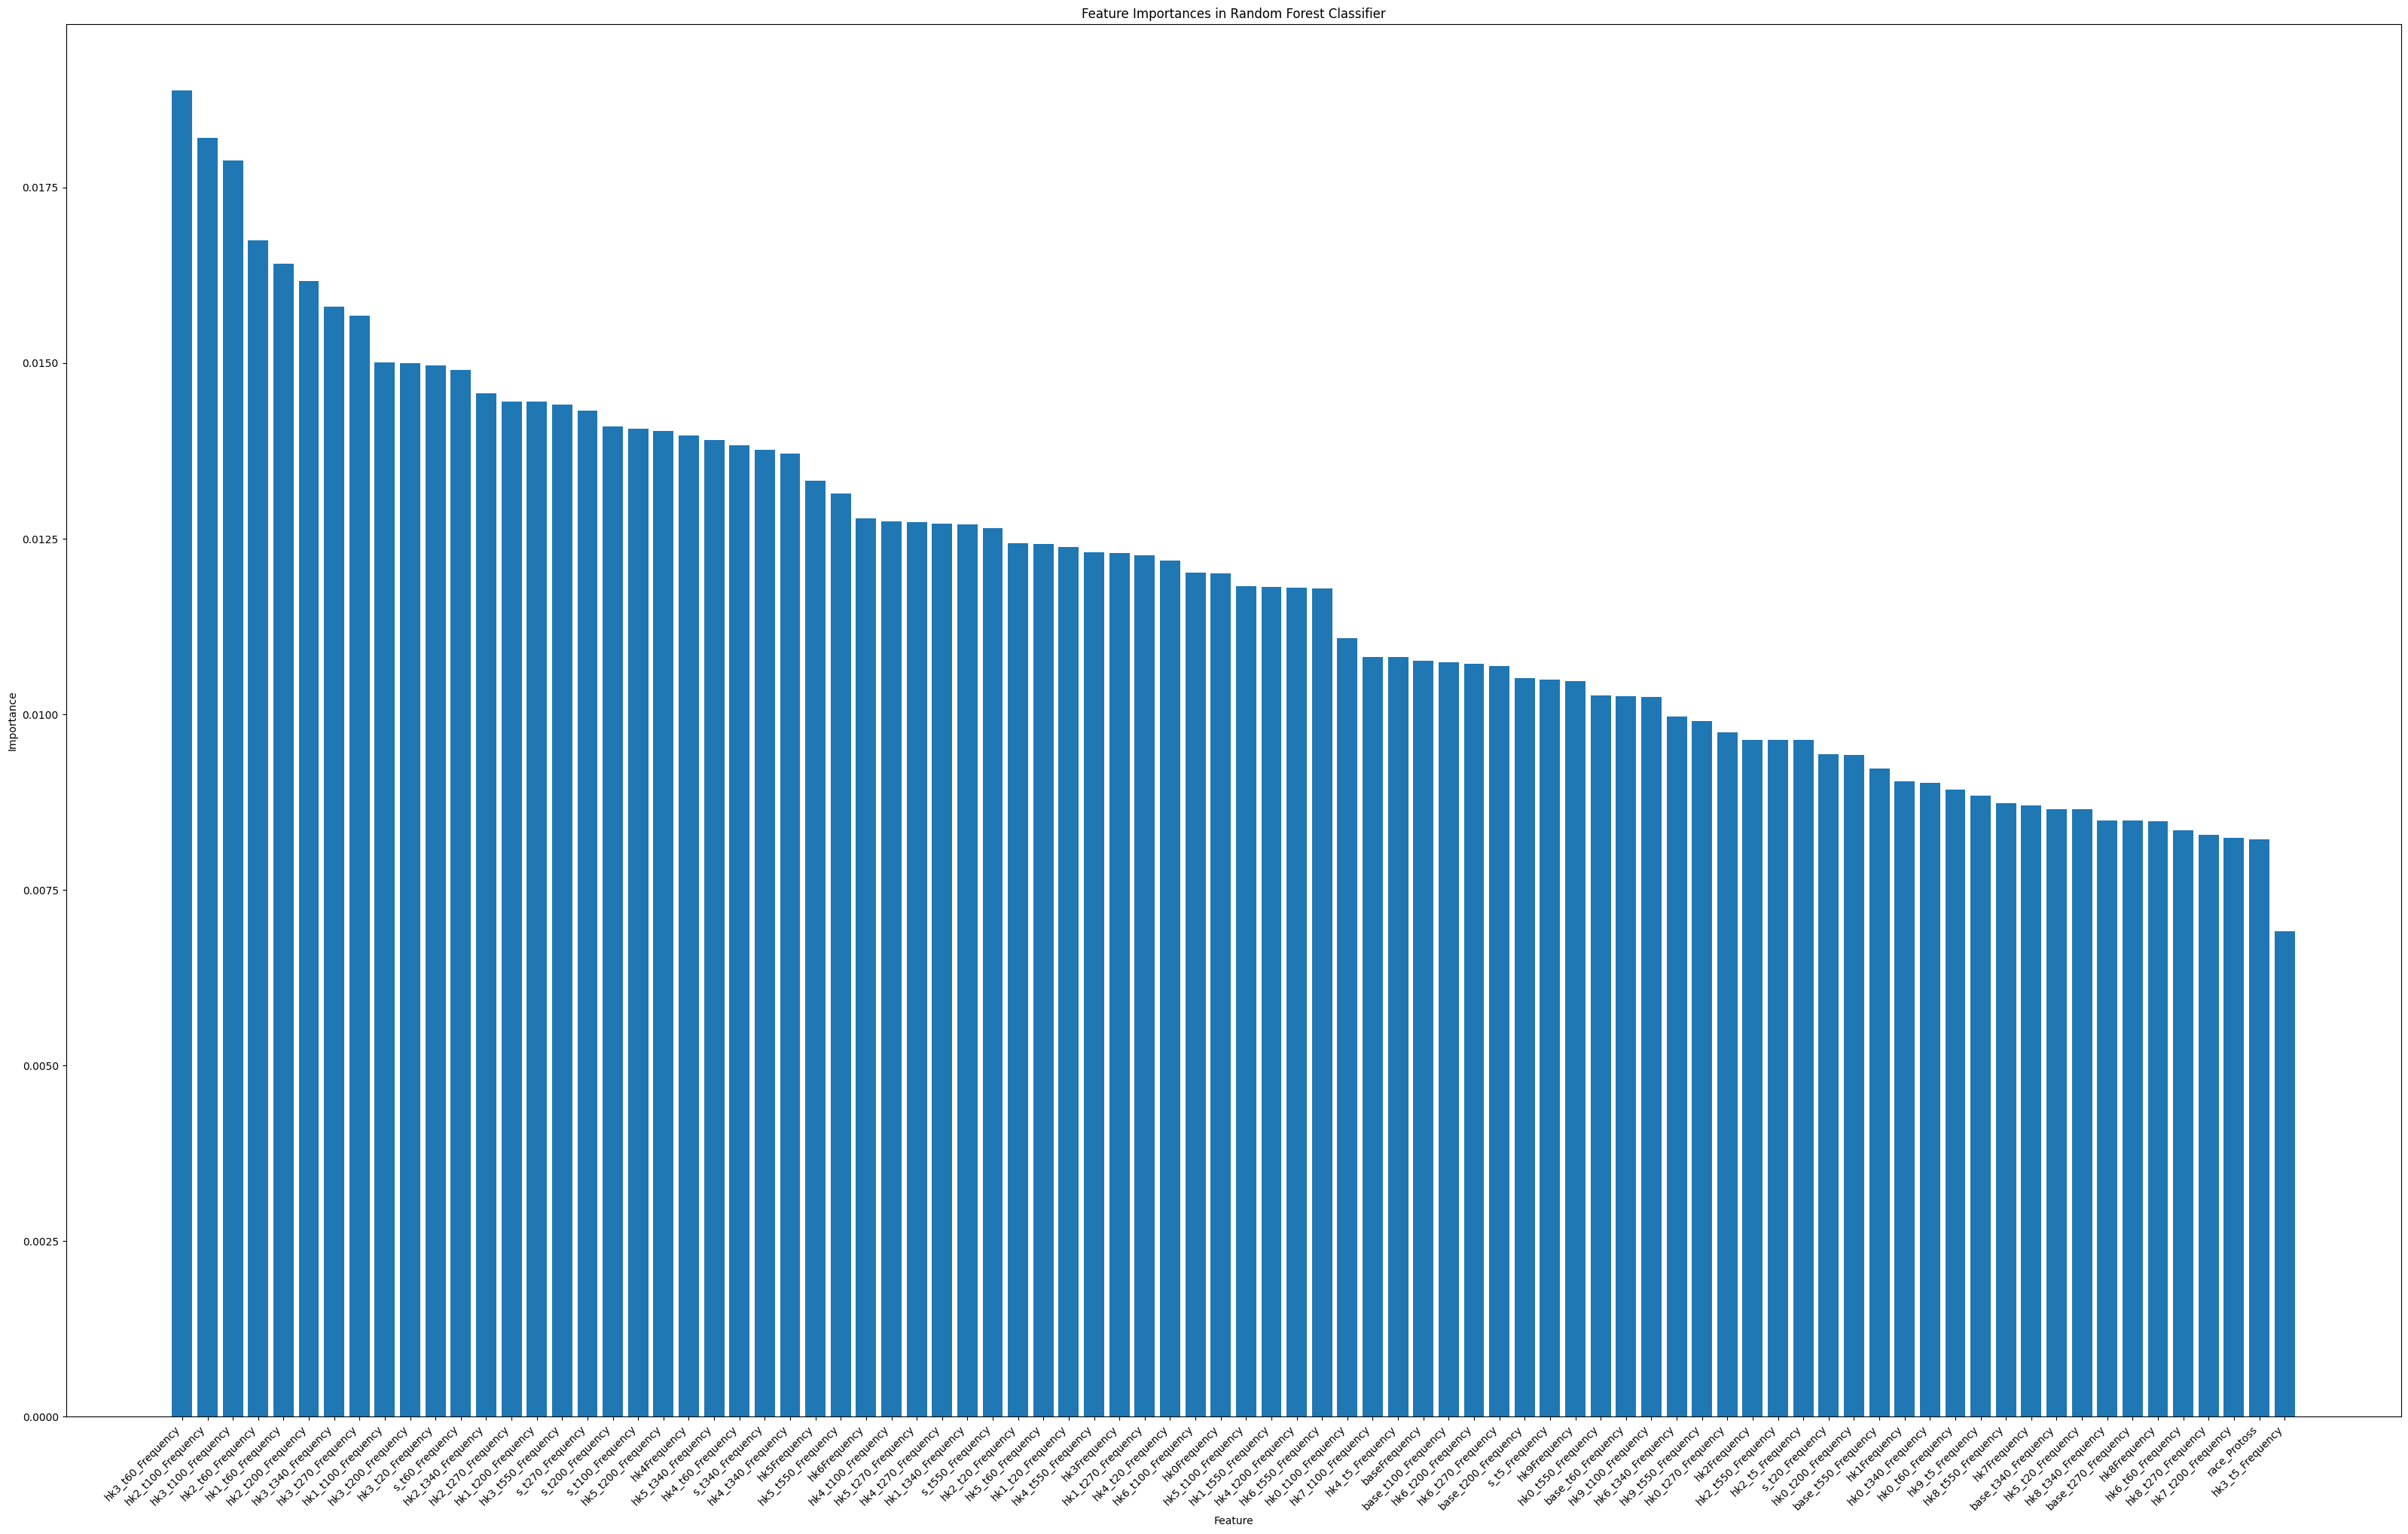

In [6]:
# Explore feature importances
feature_importances = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Sort features by their importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(40, 24))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[sorted_idx], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances in Random Forest Classifier")
plt.show()